# Part 4 - Application

The main idea, which I'll cover in the post focuses on taking our predictions and using the "probability" distriubtions generated by the model in the wOBA calculation - rather than evaluating based on result entirely, we'll evaluate based on likelihoood of possible results. 

The heavy lifting for this part of the project was in the scraping in order to get the data here. The script ```python/woba_data_generate.py``` does all the work, puts into a dataframe, and here I'll just investigate the data and generate visualizations.

Basically we have wOBA from Fangraphs, model-based calculation of wOBA (using probabilities), and then xwOBA from Savant, which is close in philosophy to what we're doing here. Players included are all qualified players, 2019 data.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

FG_LABEL = 'wOBA (FanGraphs)'
MODEL_LABEL = 'Model wOBA'
SV_LABEL = 'xwOBA (Savant)'

In [2]:
df = pd.read_csv("../data/model_output.csv")
print(f"Evaluating for {len(df)} Players")
df.head()

Evaluating for 135 Players


,idx,name,team,playerid,fg_woba,model_woba,xwoba,bb,hbp,single,double,triple,hr,p_single,p_double,p_triple,p_hr,babip
0,0,Christian Yelich,Brewers,592885,0.442,0.716224,0.419,64,8,85,29,3,44,266.48230,31.841137,4.680307,39.325710,0.355
1,1,Mike Trout,Angels,545361,0.436,0.760850,0.455,96,16,63,27,2,45,276.24220,28.274590,5.132750,44.085163,0.298
2,2,Alex Bregman,Astros,608324,0.418,0.608666,0.378,117,9,84,37,2,41,253.36337,40.769043,3.383286,29.044365,0.281
3,3,Nelson Cruz,Twins,443558,0.417,0.639322,0.417,48,7,74,26,0,41,212.89214,26.435314,0.837176,36.346400,0.351
4,4,Cody Bellinger,Dodgers,641355,0.415,0.625795,0.429,74,3,86,34,3,47,229.01820,46.272140,6.437922,41.888317,0.302


### First, just a pairplot of the 3 wOBA options 

To make sure that nothing has gone crazy awry

<Figure size 576x432 with 0 Axes>

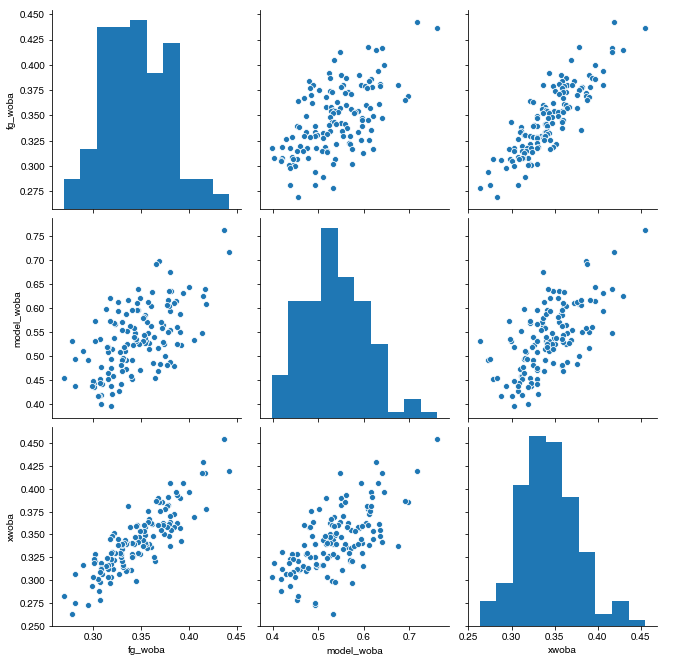

In [3]:
fig = plt.figure(figsize=(8,6))
_=sns.pairplot(df[["fg_woba","model_woba","xwoba"]], height=3)
plt.savefig("../run/part4/woba_pairplot", bbox_inches='tight')

In [4]:
df[["fg_woba","model_woba","xwoba"]].corr()

,fg_woba,model_woba,xwoba
fg_woba,1.000000,0.594004,0.859962
model_woba,0.594004,1.000000,0.647155
xwoba,0.859962,0.647155,1.000000


They are correlated, this is good. Some notes:
- xWOBA is more correlated to wOBA than my model. Implies my model diverges more from actual outcomes, which isn't necessarily a problem, just means it's either giving higher credence to alternate outcomes, or far-off outcomes (e.g. outs with high HR likelihood have more effect than outs with high 1B likelihood).
- My model is more correlated to xWOBA than true wOBA. This is a good sanity check, since theirs applies a model too and isn't 100% results based.

### Make an overlaid histogram to get a better feel for the distributions

This should give a better idea of data treatment (leave alone? Rescale? Standardize?)

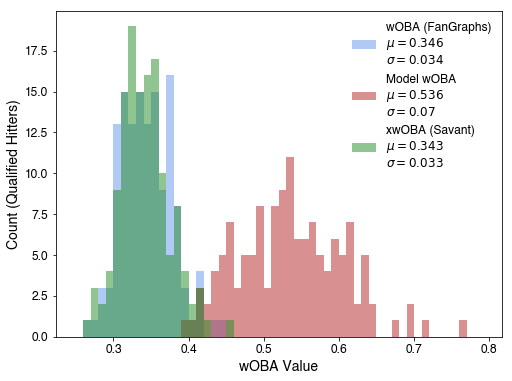

In [5]:

fig = plt.figure(figsize=(8,6))

def add_stat_to_label(data, label):
    """add mean and std to label"""
    return label+f"\n$\mu={round(data.mean(),3)}$\n$\sigma={round(data.std(),3)}$"

bins = np.arange(0.25,.80,0.01)

_=plt.hist(df["fg_woba"], bins=bins,
           color="cornflowerblue", alpha=0.5, label=add_stat_to_label(df["fg_woba"],FG_LABEL))
_=plt.hist(df["model_woba"], bins=bins,
           color="firebrick", alpha=0.5, label=add_stat_to_label(df["model_woba"],MODEL_LABEL))
_=plt.hist(df["xwoba"], bins=bins,
           color="forestgreen", alpha=0.5, label=add_stat_to_label(df["xwoba"],SV_LABEL))
plt.legend(frameon=False,fontsize=12)

plt.xlabel("wOBA Value",fontsize=14)
plt.ylabel("Count (Qualified Hitters)", fontsize=14)
plt.tick_params(labelsize=12)
plt.savefig("../run/part4/unscaled_woba_hist")

In [6]:
league_woba_mean = df["fg_woba"].mean()
league_woba_std = df["fg_woba"].std()
df["scaled_model_woba"] = league_woba_mean + (df["model_woba"] - df["model_woba"].mean()) * (league_woba_std/df["model_woba"].std())

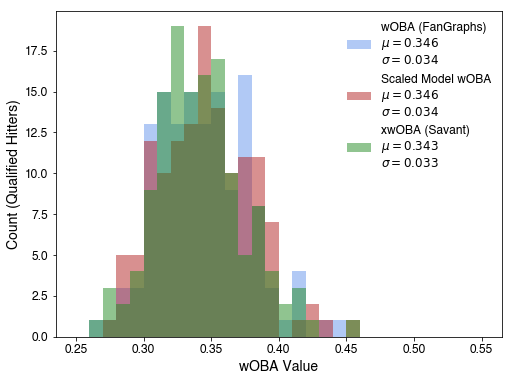

In [7]:
fig = plt.figure(figsize=(8,6))

bins = np.arange(0.25,.55,0.01)

_=plt.hist(df["fg_woba"], bins=bins,
           color="cornflowerblue", alpha=0.5, label=add_stat_to_label(df["fg_woba"],FG_LABEL))
_=plt.hist(df["scaled_model_woba"], bins=bins,
           color="firebrick", alpha=0.5, label="Scaled "+add_stat_to_label(df["scaled_model_woba"],MODEL_LABEL))
_=plt.hist(df["xwoba"], bins=bins,
           color="forestgreen", alpha=0.5, label=add_stat_to_label(df["xwoba"],SV_LABEL))
plt.legend(frameon=False,fontsize=12)

plt.xlabel("wOBA Value",fontsize=14)
plt.ylabel("Count (Qualified Hitters)", fontsize=14)
plt.tick_params(labelsize=12)
plt.savefig("../run/part4/scaled_woba_hist")

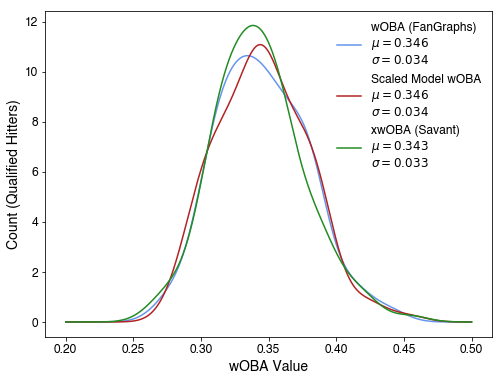

In [8]:
from scipy import stats

kde_woba = stats.gaussian_kde(df["fg_woba"])
kde_model = stats.gaussian_kde(df["scaled_model_woba"])
kde_xwoba = stats.gaussian_kde(df["xwoba"])
x = np.linspace(0.20, 0.50, 1000)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, kde_woba(x), color="cornflowerblue", label=add_stat_to_label(df["fg_woba"],FG_LABEL))
ax.plot(x, kde_model(x), color="firebrick", label="Scaled "+add_stat_to_label(df["scaled_model_woba"],MODEL_LABEL))
ax.plot(x, kde_xwoba(x), color="forestgreen", label=add_stat_to_label(df["xwoba"],SV_LABEL))

plt.xlabel("wOBA Value",fontsize=14)
plt.ylabel("Count (Qualified Hitters)", fontsize=14)
plt.tick_params(labelsize=12)

plt.legend(frameon=False,fontsize=12)
plt.savefig("../run/part4/scaled_woba_kde")

### Look at players affected most

First - players that have a higher model-based wOBA than true. Those were the most "unlucky" in terms of actual results

In [9]:
df["woba_difference"] = df["scaled_model_woba"] - df["fg_woba"]
df.sort_values("woba_difference", ascending=False).head(10)

,idx,name,team,playerid,fg_woba,model_woba,xwoba,bb,hbp,single,double,triple,hr,p_single,p_double,p_triple,p_hr,babip,scaled_model_woba,woba_difference
106,106,Dansby Swanson,Braves,621020,0.317,0.619972,0.345,49,5,75,26,3,17,249.27830,34.351470,5.172139,16.512375,0.300,0.385924,0.068924
133,133,Mallex Smith,Mariners,605480,0.278,0.531427,0.263,42,11,82,19,9,6,251.86357,18.486992,6.256121,6.005159,0.302,0.343257,0.065257
113,113,Willy Adames,Rays,642715,0.313,0.598583,0.315,45,3,89,25,1,20,277.26780,26.375792,2.999971,18.588520,0.320,0.375617,0.062617
124,124,Rougned Odor,Rangers,596059,0.302,0.572886,0.321,50,5,46,30,1,30,227.97626,29.443344,3.210832,27.810234,0.244,0.363235,0.061235
95,95,Dexter Fowler,Cardinals,451594,0.326,0.611599,0.338,73,8,72,24,1,19,257.62997,27.302748,3.087470,16.302387,0.294,0.381890,0.055890
38,38,Bryce Harper,Phillies,547180,0.365,0.690739,0.387,88,6,77,36,1,35,322.02255,35.245205,4.492688,35.324417,0.313,0.420024,0.055024
35,35,Ronald Acuna Jr.,Braves,660670,0.369,0.697374,0.386,72,9,110,22,2,41,348.81580,30.504860,9.654206,42.388863,0.337,0.423222,0.054222
62,62,Rhys Hoskins,Phillies,656555,0.347,0.640076,0.342,110,11,62,33,5,29,304.05905,34.166850,0.758610,28.377266,0.267,0.395612,0.048612
76,76,Marcell Ozuna,Cardinals,542303,0.336,0.616310,0.381,60,1,64,23,1,29,228.99799,31.097208,2.084045,28.217678,0.257,0.384159,0.048159
94,94,Domingo Santana,Mariners,570267,0.326,0.594560,0.345,49,2,72,20,1,21,219.02286,22.712784,1.229896,22.854729,0.347,0.373679,0.047679


And those that have higher wOBA than model got "lucky"

In [10]:
df.sort_values("woba_difference", ascending=True).head(10)

,idx,name,team,playerid,fg_woba,model_woba,xwoba,bb,hbp,single,double,triple,hr,p_single,p_double,p_triple,p_hr,babip,scaled_model_woba,woba_difference
15,15,Jeff McNeil,Mets,643446,0.384,0.478806,0.358,33,21,100,38,1,23,159.41586,37.002130,3.466941,22.490639,0.337,0.317900,-0.066100
5,5,Anthony Rendon,Nationals,543685,0.413,0.547795,0.417,72,12,93,44,3,34,192.90694,44.268830,1.947190,34.280212,0.323,0.351144,-0.061856
6,6,Ketel Marte,Diamondbacks,606466,0.405,0.533215,0.369,51,4,110,36,9,32,210.89734,44.241390,4.913987,26.232239,0.342,0.344118,-0.060882
39,39,Yuli Gurriel,Astros,493329,0.364,0.454462,0.321,35,5,95,40,2,31,196.07341,35.791610,2.390028,16.095867,0.289,0.306170,-0.057830
27,27,Rafael Devers,Red Sox,646240,0.377,0.481674,0.358,41,4,111,54,4,32,204.02237,53.622140,4.611492,27.477772,0.339,0.319282,-0.057718
20,20,Carlos Santana,Indians,467793,0.380,0.488140,0.364,96,3,96,30,1,34,191.53427,31.501305,1.478513,27.513672,0.293,0.322398,-0.057602
37,37,Michael Brantley,Astros,488726,0.367,0.468478,0.360,48,7,115,40,2,22,196.07806,34.542206,3.581811,21.009998,0.320,0.312924,-0.054076
9,9,Nolan Arenado,Rockies,571448,0.392,0.523943,0.343,51,4,111,31,2,41,216.66995,39.917988,2.357287,32.130730,0.312,0.339651,-0.052349
34,34,Justin Turner,Dodgers,457759,0.370,0.484271,0.376,50,14,88,24,0,27,154.39265,33.701656,1.022085,22.636654,0.304,0.320534,-0.049466
12,12,Charlie Blackmon,Rockies,453568,0.387,0.525455,0.363,39,9,101,42,7,32,210.20927,42.224045,5.229419,29.364819,0.334,0.340379,-0.046621


### Make comparison plot

Interactive plot with Bokeh

In [11]:
from bokeh.plotting import figure, show, output_file
from bokeh.models.tools import HoverTool

In [12]:
# split on most/least improved
most_improved = df.sort_values("woba_difference", ascending=False)[:5]
most_reduced = df.sort_values("woba_difference", ascending=False)[-5:]
others = df.sort_values("woba_difference", ascending=False)[5:][:-5]

In [13]:
p = figure()

p = figure(title="2019 Data", toolbar_location="above")

# y=x line
x_line = np.linspace(min(df["fg_woba"])-.005, max(df["scaled_model_woba"]+.005),1000)
p.line(x=x_line, y=x_line, line_color="grey", line_width=2, line_alpha=0.6)

# Plot points
improved_glyph = p.circle( x="fg_woba", y="scaled_model_woba", source=most_improved, color="forestgreen", alpha=0.6, size=8)
reduced_glyph = p.circle( x="fg_woba", y="scaled_model_woba", source=most_reduced, color="firebrick", alpha=0.6, size=8)
others_glyph = p.circle( x="fg_woba", y="scaled_model_woba", source=others, color="cornflowerblue", alpha=0.6, size=8)

hover_points = HoverTool(renderers=[improved_glyph, reduced_glyph, others_glyph])
hover_points.tooltips=[
    ('Name', '@name (@team)'),
    ('wOBA (FanGraphs)', '@fg_woba'),
    ('Model wOBA', '@scaled_model_woba'),
    ('xwOBA (Savant)', '@xwoba'),
]

p.title.text_font_size = "18pt"
p.xaxis.axis_label="wOBA (FanGraphs)"
p.xaxis.axis_label_text_font_size = "15pt"
p.xaxis.major_label_text_font_size = "12pt"
p.xaxis.axis_label_text_font_style = 'normal'
p.yaxis.axis_label="Model wOBA"
p.yaxis.axis_label_text_font_size = "15pt"
p.yaxis.major_label_text_font_size = "12pt"

p.yaxis.axis_label_text_font_style = 'normal'
p.add_tools(hover_points)
output_file("../run/part4/bokeh_html.html")
show(p)

In [14]:
# Output plot
from bokeh.embed import file_html
from bokeh.resources import CDN
from bokeh.io import output_file
html = file_html(p, CDN, "Model wOBA vs wOBA")
output_file("../run/part4/bokeh_html.html")
#with open("../run/part4/bokeh_html.html","w+") as f:
#    f.write(html)